# Intro

There are a number of python packages to work with FCA. In this notebook we will compare their performances in the basic FCA task: constructing the concept lattice from a formal context.

We consider three packages: FCApy, fcapsy and Concepts

// More packages can be compared in the future

# Install competitors libraries

The current `FCApy` library (by Egor Dudyrev, HSE Moscow): https://github.com/EgorDudyrev/FCApy 

In [1]:
from fcapy import LIB_INSTALLED
from fcapy.context import FormalContext, converters
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import Visualizer

`Concepts` package (by Sebastian Bank, University of Leipzig): https://github.com/xflr6/concepts

In [2]:
import concepts

`fcapsy` package (by Tomáš Mikula, Palacký University): https://github.com/mikulatomas/fcapsy

In [3]:
import fcapsy

# Load data

First we load some classic FCA contexts (datasets)

In [4]:
frames_classic = {}
contexts_to_test = ['animal_movement', 'digits', 'gewaesser',
                    'lattice', 'liveinwater', 'tealady']

!rm -rf tmp
!mkdir tmp

for ctx_name in contexts_to_test:
    fname = f'tmp/{ctx_name}.cxt'
    !wget -O {fname} -q https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/{ctx_name}.cxt
    ctx = converters.read_cxt(fname)
    df = ctx.to_pandas()
    df.name = ctx_name
    frames_classic[ctx_name] = df
!rm -rf tmp

These classic real world contexts are small so we add some big random contexts to our examination

// Omit this part for now

In [5]:
import numpy as np
import pandas as pd
from itertools import product

np.random.seed(42)
n_objects_vars = [10, 15,]
n_attributes_vars = [10, 15]
densities_vars = [0.1, 0.5, 0.9]
frames_random = {}
for comb in product(n_objects_vars, n_attributes_vars, densities_vars):
    n_objects, n_attributes, density = comb

    frame = pd.DataFrame(np.random.binomial(1, density, size=(n_objects,n_attributes)))
    frame.columns = [f"m_{i}" for i in frame.columns]
    frame.index = [f"g_{i}" for i in frame.index]
    frame = frame.astype(bool)

    frame.name = f"random_{n_objects}_{n_attributes}_{density}"
    frames_random[frame.name] = frame

In [6]:
frames = dict(frames_classic, **frames_random)

# Run benchmarks

## Default lattice visualizations

In [7]:
df = frames['animal_movement']
df

,fly,hunt,run,swim
dove,True,False,False,False
hen,False,False,False,False
duck,True,False,False,True
goose,True,False,False,True
owl,True,True,False,False
hawk,True,True,False,False
eagle,True,True,False,False
fox,False,True,True,False
dog,False,False,True,False
wolf,False,True,True,False


### Visualization by `concepts`

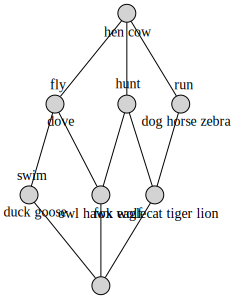

In [8]:
ctx_concepts = concepts.Context(df.index, df.columns, df.values)
ctx_concepts.lattice.graphviz()

### Visualization by `fcapy`

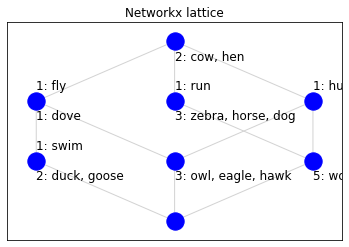

In [9]:
import matplotlib.pyplot as plt

ctx_fcapy = FormalContext.from_pandas(df)
ltc_fcapy = ConceptLattice.from_context(ctx_fcapy)
vsl_fcapy = Visualizer(ltc_fcapy)

plt.title('Networkx lattice')
vsl_fcapy.draw_networkx()
#vsl_fcapy.get_plotly_figure(title='Plotly lattice')

## Time to construct a lattice

In [10]:
from datetime import datetime
def run_concepts(frame):
    ctx = concepts.Context(frame.index, frame.columns, frame.values)
    
    t1 = datetime.now()
    ltc = ctx.lattice
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    stat = {'lattice_construction_time (secs)': dt}
    return stat

def run_fcapy(frame):
    LIB_INSTALLED['numpy'] = False
    ctx = FormalContext.from_pandas(frame)
    
    t1 = datetime.now()
    ltc = ConceptLattice.from_context(ctx, algo='CbO')
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    stat = {'lattice_construction_time (secs)': dt}
    return stat

def run_fcapsy(frame):
    ctx = fcapsy.Context.from_pandas(frame)
    
    t1 = datetime.now()
    ltc = fcapsy.Lattice(ctx)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    stat = {'lattice_construction_time (secs)': dt}
    return stat

In [11]:
def get_context_stat(frame):
    ctx_stat = {
        'ctx_name': frame.name,
        'n_objects': frame.shape[0], 'n_attributes': frame.shape[1],
        'n_connections': frame.sum().sum(),
        'density': frame.sum().sum()/(frame.shape[0]*frame.shape[1]),
    }
    return ctx_stat

In [12]:
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
n_runs = 100

stats_total = []
for ctx_name, frame in tqdm(frames.items(), total=len(frames)):
    ctx_stat = get_context_stat(frame)
    if ctx_stat['ctx_name'] == 'random_15_15_0.9':
        # works to slow on this context
        continue
    
    stats_per_ctx = []
    for lib_name, run_func in [
        ('concepts', run_concepts),
        ('fcapy', run_fcapy),
        ('fcapsy', run_fcapsy)
    ]:
        for run_number in tqdm(range(n_runs), leave=False, desc=lib_name):
            stat = run_func(frame)
            stat = dict(stat, library=lib_name, run_number=run_number, **ctx_stat)
            stats_per_ctx.append(stat)
    stats_total += stats_per_ctx

In [ ]:
stats_df = pd.DataFrame(stats_total)
stats_df['is_random'] = [x.startswith('random') for x in stats_df['ctx_name']]
stats_df.head()

In [ ]:
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # (1,1,1,0)

In [ ]:
context_stat_feats = ['n_objects', 'n_attributes', 'n_connections', 'density']
y_feat = 'lattice_construction_time (secs)'
width = 2

plt.figure(figsize=(10,7))
for idx, x_feat in enumerate(context_stat_feats):
    plt.subplot(len(context_stat_feats)//width+1, width, idx+1)
    sns.lineplot(x=x_feat, y=y_feat, hue='library', data=stats_df[~stats_df['is_random']])
    plt.xlabel(''); plt.ylabel('')
    plt.title(x_feat)
    plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(f"{y_feat} based on context statistics\nreal world data")
plt.show()

In [ ]:
context_stat_feats = ['n_objects', 'n_attributes', 'n_connections', 'density']
y_feat = 'lattice_construction_time (secs)'
width = 2

plt.figure(figsize=(10,7))
for idx, x_feat in enumerate(context_stat_feats):
    plt.subplot(len(context_stat_feats)//width+1, width, idx+1)
    sns.lineplot(x=x_feat, y=y_feat, hue='library', data=stats_df[stats_df['is_random']])
    plt.xlabel(''); plt.ylabel('')
    plt.title(x_feat)
    plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(f"{y_feat} based on context statistics\nrandom contexts")
plt.show()

In [ ]:
context_stat_feats = ['n_objects', 'n_attributes', 'n_connections', 'density']
y_feat = 'lattice_construction_time (secs)'
width = 2

plt.figure(figsize=(10,7))
for idx, x_feat in enumerate(context_stat_feats):
    plt.subplot(len(context_stat_feats)//width+1, width, idx+1)
    sns.lineplot(x=x_feat, y=y_feat, hue='library', data=stats_df)
    plt.xlabel(''); plt.ylabel('')
    plt.title(x_feat)
    plt.yscale('log')
    plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(f"{y_feat} based on context statistics\nall the data in log scale")
plt.show()

In [ ]:
context_stat_df = stats_df[['ctx_name',]+context_stat_feats].drop_duplicates().reset_index(drop=True)
print('Contexts statistics')
context_stat_df